In [1]:
import os 
import sys
import json
import pickle

from tqdm import tqdm
import numpy as np
import pandas as pd

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..")))


# Define the path to the dataset
base_path = os.path.join(os.path.dirname(os.getcwd()))
base_path

'/root/exPress/PlayerImputer'

In [2]:
from datatools.trace_snapshot import TraceSnapshot
from datatools.utils import compute_camera_coverage, is_inside
import imputer.config as config

In [3]:
import datatools.pitch_control as pc
import datatools.visualization as ut

/root/exPress/PlayerImputer


In [4]:
# 데이터 및 모델 경로
data_dir = os.path.join(base_path, "data" ,"DFL")
model_path = os.path.join(base_path, "stores", "transformer", "072") # 036
model_path = os.path.join(base_path, "stores", "xgboost", "033") # 036
params_path = os.path.join(model_path, "params.json")

with open(params_path, "r") as f:
    all_params = json.load(f)
    params = all_params.get("transformer", {})

scaler_path = os.path.join(base_path, "imputer", "scalers")
params["save_path"] = model_path 
params["scaler_path"] = scaler_path 
params

{'ModelConfig': {'dim_hidden': 512,
  'num_heads': 8,
  'num_layers': 6,
  'dropout': 0.0,
  'dim_feedforward': 768,
  'ln': True},
 'DataConfig': {'batch_size': 16,
  'num_workers': 30,
  'pin_memory': True,
  'prefetch_factor': 2},
 'TrainerConfig': {'max_epochs': 100,
  'min_epochs': 100,
  'accelerator': 'gpu',
  'gradient_clip_val': 5.0,
  'check_val_every_n_epoch': 1},
 'OptimizerConfig': {'optimizer_params': {'lr': 0.0001,
   'weight_decay': 1e-05}},
 'EarlyStopConfig': {'patience': 5,
  'min_delta': 0.001,
  'mode': 'min',
  'strict': False,
  'verbose': True},
 'ModelCheckpoint': {'save_top_k': 1, 'verbose': True, 'mode': 'min'},
 'save_path': '/root/exPress/PlayerImputer/stores/xgboost/033',
 'scaler_path': '/root/exPress/PlayerImputer/imputer/scalers'}

In [5]:
args_path = os.path.join(model_path, "args.json")
with open(args_path, "r") as f:
    args = json.load(f)
args

{'mode': 'train',
 'model': 'xgboost',
 'trial': 33,
 'params_file': 'imputer_params.json',
 'data_dir': 'data/DFL',
 'optimized_metric': None,
 'window': 41,
 'xfns': ['prevAgentX',
  'prevAgentY',
  'prevAgentTime',
  'nextAgentX',
  'nextAgentY',
  'nextAgentTime',
  'avgAgentX',
  'avgAgentY',
  'agentSide',
  'agentRole',
  'agentObserved',
  'goalDiff',
  'eventX',
  'eventY',
  'eventType'],
 'yfns': ['coordinates'],
 'test_only': False,
 'fold_mode': 'simple'}

In [6]:
# 데이터셋 파일 경로 만들기
dataset_filename = f'{args["model"]}_{args["window"]}_test_{"_".join(args["yfns"])}_dataset.pkl'
# dataset_pkl_path = os.path.join(base_path, "data", "DFL", "freeze_frame_data", dataset_filename)
dataset_pkl_path = os.path.join(base_path, "data", "DFL", "transformer", dataset_filename)
dataset_pkl_path = os.path.join(base_path, "data", "DFL", dataset_filename)

with open(dataset_pkl_path, "rb") as f:
    test_dataset = pickle.load(f)
test_dataset

In [7]:
dataset_pkl_path

'/root/exPress/PlayerImputer/data/DFL/xgboost_41_test_coordinates_dataset.pkl'

In [8]:
checkpoint_path = os.path.join(model_path, "best_model.ckpt")
checkpoint_path

'/root/exPress/PlayerImputer/stores/xgboost/033/best_model.ckpt'

In [9]:
from imputer.components.model import SetTransformerModel

model=SetTransformerModel(test_dataset, params["ModelConfig"], params["OptimizerConfig"])
model

rnn_type:  STT

[모델 요약 정보]
categorical_embeddings.agentObserved.weight        | shape: (3, 1) | requires_grad: True | params: 3
categorical_embeddings.agentRole.weight            | shape: (15, 3) | requires_grad: True | params: 45
categorical_embeddings.agentSide.weight            | shape: (3, 1) | requires_grad: True | params: 3
categorical_embeddings.eventType.weight            | shape: (46, 6) | requires_grad: True | params: 276
input_fc.weight                                    | shape: (512, 22) | requires_grad: True | params: 11,264
input_fc.bias                                      | shape: (512,) | requires_grad: True | params: 512
freeze_fc.weight                                   | shape: (512, 5) | requires_grad: True | params: 2,560
freeze_fc.bias                                     | shape: (512,) | requires_grad: True | params: 512
player_encoder.layers.0.self_attn.in_proj_weight   | shape: (1536, 512) | requires_grad: True | params: 786,432
player_encoder.layers.0.self_a

SetTransformerModel(
  (model): SetTransformer(
    (categorical_embeddings): ModuleDict(
      (agentObserved): Embedding(3, 1, padding_idx=0)
      (agentRole): Embedding(15, 3, padding_idx=0)
      (agentSide): Embedding(3, 1, padding_idx=0)
      (eventType): Embedding(46, 6, padding_idx=0)
    )
    (input_fc): Linear(in_features=22, out_features=512, bias=True)
    (freeze_fc): Linear(in_features=5, out_features=512, bias=True)
    (player_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=1024, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (linear2): Linear(in_features=1024, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): Laye

In [10]:
pkl_path = os.path.join(model_path, "component.pkl")
pkl_path

'/root/exPress/PlayerImputer/stores/xgboost/033/component.pkl'

In [11]:
from pathlib import Path
component = pickle.load(Path(pkl_path).open(mode="rb"))
component

In [12]:
# from imputer.components import press
# component = press.SetTransformerComponent(model=model, params=params)
# component.load(checkpoint_path)
# component.model.eval()
# component

In [13]:
import ast
df = pd.read_csv("./41_predict_result.csv", index_col=0)
def safe_eval(x):
    try:
        return ast.literal_eval(x)
    except Exception:
        return None  # 또는 np.nan

df["pred"] = df["pred"].apply(safe_eval)
df["target"] = df["target"].apply(safe_eval)
df

,pred,target
0,"{'A00': (57.14963150024414, 38.12494659423828)...","{'A00': (57.92000198364258, 25.920000076293945..."
1,"{'A00': (62.05221176147461, 38.298011779785156...","{'A00': (51.584999084472656, 21.94000053405761..."
2,"{'A00': (64.68743133544922, 33.08012771606445)...","{'A00': (54.56000518798828, 18.25), 'A01': (97..."
3,"{'A00': (59.88539123535156, 34.96697998046875)...","{'A00': (60.03499984741211, 13.109999656677246..."
4,"{'A00': (68.61933898925781, 31.233570098876953...","{'A00': (64.71499633789062, 9.859999656677246)..."
...,...,...
1355,"{'A01': (85.26119232177734, 37.66334915161133)...","{'A01': (98.61000061035156, 35.0099983215332),..."
1356,"{'A01': (79.52930450439453, 37.447776794433594...","{'A01': (98.61000061035156, 35.02000045776367)..."
1357,"{'A01': (77.47050476074219, 36.091400146484375...","{'A01': (98.61000061035156, 35.0), 'A02': (49...."
1358,"{'A01': (79.51557922363281, 34.79013442993164)...","{'A01': (98.61000061035156, 35.0), 'A02': (49...."


In [14]:
# ✅ 예측 수행
df = component.predict(test_dataset)
df

torch.Size([1360, 40, 2]) torch.Size([1360, 40, 2])
accuracy:  0.515274064171123
x: 9.378, y: 6.934, xy: 12.880


,pred,target
0,"{'A00': (43.22570037841797, 36.78055191040039)...","{'A00': (57.92000198364258, 25.920000076293945..."
1,"{'A00': (40.75815200805664, 39.11543273925781)...","{'A00': (51.584999084472656, 21.94000053405761..."
2,"{'A00': (47.7350959777832, 36.2410888671875), ...","{'A00': (54.56000518798828, 18.25), 'A01': (97..."
3,"{'A00': (52.61823654174805, 31.17592430114746)...","{'A00': (60.03499984741211, 13.109999656677246..."
4,"{'A00': (57.347511291503906, 29.80418968200683...","{'A00': (64.71499633789062, 9.859999656677246)..."
...,...,...
1355,"{'A01': (81.20674896240234, 41.23737716674805)...","{'A01': (98.61000061035156, 35.0099983215332),..."
1356,"{'A01': (78.56294250488281, 42.040367126464844...","{'A01': (98.61000061035156, 35.02000045776367)..."
1357,"{'A01': (77.19837951660156, 40.986392974853516...","{'A01': (98.61000061035156, 35.0), 'A02': (49...."
1358,"{'A01': (77.3103256225586, 40.34172439575195),...","{'A01': (98.61000061035156, 35.0), 'A02': (49...."


In [14]:
events = test_dataset.events
print(events["game_id"].unique())
events

['DFL-MAT-J03WR9']


,type_name,time_seconds,team_id,player_id,outcome,timestamp,minute,second,qualifier,period_id,team,game_id,start_x,start_y,position,related_x,related_y,related_id,event_id
0,KickOff_Play_Pass,0.000,DFL-CLU-00000P,DFL-OBJ-00008K,NaN,2022-11-11 18:31:11.980000+01:00,0.0,0.0,"{'TeamRight': 'DFL-CLU-00000I', 'TeamLeft': 'D...",1,Home,DFL-MAT-J03WR9,52.830000,34.330000,STL,27.570000,34.840000,DFL-OBJ-0028FW,0
1,Play_Pass,3.085,DFL-CLU-00000P,DFL-OBJ-0028FW,NaN,2022-11-11 18:31:15.065000+01:00,0.0,3.0,"{'Player': 'DFL-OBJ-0028FW', 'Distance': 'long...",1,Home,DFL-MAT-J03WR9,28.400016,37.039986,TW,67.190042,2.360010,DFL-OBJ-002FXT,1
2,TacklingGame,4.941,DFL-CLU-00000P,DFL-OBJ-002FXT,0.0,2022-11-11 18:31:16.921000+01:00,0.0,4.0,"{'WinnerResult': 'layoff', 'Loser': 'DFL-OBJ-0...",1,Home,DFL-MAT-J03WR9,73.829977,5.009947,STR,74.289947,16.220129,DFL-OBJ-0028GO,2
3,Play_Pass,6.430,DFL-CLU-00000P,DFL-OBJ-002FXT,NaN,2022-11-11 18:31:18.410000+01:00,0.0,6.0,"{'Player': 'DFL-OBJ-002FXT', 'Distance': 'medi...",1,Home,DFL-MAT-J03WR9,72.660036,10.609956,STR,80.619952,20.260064,DFL-OBJ-00008K,3
4,Play_Pass,7.662,DFL-CLU-00000P,DFL-OBJ-00008K,NaN,2022-11-11 18:31:19.642000+01:00,0.0,7.0,"{'Player': 'DFL-OBJ-00008K', 'Distance': 'shor...",1,Home,DFL-MAT-J03WR9,82.879964,16.750036,STL,99.499964,31.790007,DFL-OBJ-00003W,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1355,Nutmeg,2955.700,DFL-CLU-00000I,DFL-OBJ-0028G2,NaN,2022-11-11 20:22:38.720000+01:00,49.0,15.0,"{'Player': 'DFL-OBJ-0028G2', 'AffectedTeam': '...",2,Away,DFL-MAT-J03WR9,18.380008,59.959936,ORM,NaN,NaN,NaN,1355
1356,Play_Pass,2956.127,DFL-CLU-00000I,DFL-OBJ-0028G2,NaN,2022-11-11 20:22:39.147000+01:00,49.0,16.0,"{'Player': 'DFL-OBJ-0028G2', 'Distance': 'medi...",2,Away,DFL-MAT-J03WR9,18.780011,59.359989,ORM,NaN,NaN,NaN,1356
1357,TacklingGame,2957.980,DFL-CLU-00000I,DFL-OBJ-002GPI,0.0,2022-11-11 20:22:41+01:00,49.0,17.0,"{'WinnerResult': 'fouled', 'Loser': 'DFL-OBJ-J...",2,Away,DFL-MAT-J03WR9,4.909904,47.659936,STZ,63.490104,19.280024,DFL-OBJ-J01KJ5,1357
1358,Foul,2958.220,DFL-CLU-00000P,DFL-OBJ-J01KJ5,NaN,2022-11-11 20:22:41.240000+01:00,49.0,18.0,"{'TeamFouled': 'DFL-CLU-00000I', 'FoulType': '...",2,Home,DFL-MAT-J03WR9,3.879936,48.569992,LV,NaN,NaN,NaN,1358


In [15]:
team_sheets = pd.read_csv(os.path.join(base_path, "data", "DFL", events["game_id"].unique()[0], 'teams.csv'))

print(team_sheets["team_id"].unique())
team_sheets

['DFL-CLU-00000P' 'DFL-CLU-00000I']


,player,position,team,jID,player_id,team_id,xID
0,A. Bodzek,None,Home,13,DFL-OBJ-00005H,DFL-CLU-00000P,0
1,R. Hennings,STL,Home,28,DFL-OBJ-00008K,DFL-CLU-00000P,1
2,R. Wolf,None,Home,1,DFL-OBJ-000170,DFL-CLU-00000P,2
3,Matthias Zimmermann,RV,Home,25,DFL-OBJ-0000NZ,DFL-CLU-00000P,3
4,A. Hoffmann,None,Home,3,DFL-OBJ-00006V,DFL-CLU-00000P,4
5,F. Klaus,ORM,Home,11,DFL-OBJ-0000F8,DFL-CLU-00000P,5
6,Jorrit Hendrix,DML,Home,29,DFL-OBJ-J0130T,DFL-CLU-00000P,6
7,M. Sobottka,DMR,Home,31,DFL-OBJ-00028V,DFL-CLU-00000P,7
8,Dawid Kownacki,STR,Home,9,DFL-OBJ-002FXT,DFL-CLU-00000P,8
9,E. Iyoha,OLM,Home,19,DFL-OBJ-0026RH,DFL-CLU-00000P,9


In [16]:
tracking_data = pd.read_csv(os.path.join(base_path, "data", "DFL", events["game_id"].unique()[0], 'positions.csv'))
tracking_data

,H00_x,H00_y,H01_x,H01_y,H02_x,H02_y,H03_x,H03_y,H04_x,H04_y,...,A17_speed,A18_vx,A18_vy,A18_speed,A19_vx,A19_vy,A19_speed,B00_vx,B00_vy,B00_speed
0,NaN,NaN,52.83,34.33,NaN,NaN,43.06,12.32,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,52.82,34.32,NaN,NaN,43.09,12.32,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,52.82,34.30,NaN,NaN,43.11,12.32,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,52.83,34.28,NaN,NaN,43.13,12.33,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,52.84,34.27,NaN,NaN,43.15,12.33,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146805,NaN,NaN,NaN,NaN,NaN,NaN,58.80,39.67,NaN,NaN,...,1.47,0.25,-1.54,1.56,-0.14,-1.04,1.05,0.0,0.0,0.0
146806,NaN,NaN,NaN,NaN,NaN,NaN,58.78,39.63,NaN,NaN,...,1.46,0.25,-1.54,1.56,-0.18,-1.00,1.02,0.0,0.0,0.0
146807,NaN,NaN,NaN,NaN,NaN,NaN,58.77,39.60,NaN,NaN,...,1.46,0.29,-1.54,1.56,-0.21,-0.99,1.01,0.0,0.0,0.0
146808,NaN,NaN,NaN,NaN,NaN,NaN,58.76,39.56,NaN,NaN,...,1.47,0.32,-1.54,1.57,-0.23,-0.98,1.01,0.0,0.0,0.0


## Pitch Control Example

In [17]:
params = pc.default_model_params()
params

{'max_player_accel': 7.0,
 'max_player_speed': 5.0,
 'reaction_time': 0.7,
 'tti_sigma': 0.45,
 'kappa_def': 1,
 'lambda_att': 4.3,
 'lambda_def': 4.3,
 'lambda_gk': 12.899999999999999,
 'average_ball_speed': 15.0,
 'int_dt': 0.04,
 'max_int_time': 10,
 'model_converge_tol': 0.01,
 'time_to_control_att': 3.320255005554731,
 'time_to_control_def': 3.320255005554731}

In [18]:
# Generate Pitch Control for predictor models
def calculate_model_pitch_control(results_df, event_id, actual, play_left_to_right = False):
    event_df = results_df[results_df["event_id"] == event_id].copy()
    
    if actual == False:
        event_df["x"] = event_df["pred_x"].copy()
        event_df["y"] = event_df["pred_y"].copy()
    else:
        event_df["x"] = event_df["act_x"].copy()
        event_df["y"] = event_df["act_y"].copy()

        if play_left_to_right:
            event_df["x"] = config.field_length - event_df["x"].values
            event_df["y"] = config.field_width - event_df["y"].values
            
    event_df["ballx"] = config.field_length - event_df["ballx"].values
    event_df["bally"] = config.field_width - event_df["bally"].values

    # event_df.loc[event_df["team_on_ball"] == False, "x"] = config.field_length - event_df.loc[event_df["team_on_ball"] == False, "x"].values
    # event_df.loc[event_df["team_on_ball"] == False, "y"] = config.field_width - event_df.loc[event_df["team_on_ball"] == False, "y"].values

    PPCFa, _, _ = pc.generate_pitch_control_for_event(event_df.iloc[0], event_df, params, 
                                                       field_dimen=(config.field_length, config.field_width,), 
                                                       n_grid_cells_x=52, n_grid_cells_y=52*0.75, offsides=False,
    )
    fig, ax = pc.plot_pitchcontrol_for_event(PPCFa, event_df.iloc[0], event_df)
    fig.set_size_inches(12,8)

    return PPCFa, ax, event_df

def plot_pitchcontrol(event_id, PPCF, locs, alpha = 0.7, include_player_velocities=True, annotate=False, field_dimen = (105.0, 68)):
    highlight = events[events["event_id"] == event_id].iloc[0]

    row = {}
    for r in locs.itertuples():
        row[f"{r.key}_x"] = r.x
        row[f"{r.key}_y"] = r.y
    trace = pd.DataFrame.from_dict(row, orient='index').T

    # 시각화: 360에 포착되지 않는 선수 제거
    # except_id = ["H10", "H13","H14","H01","H08","H09", "H03", "A07","A12","A14","A16","A13","A06", "A01", "A05","A00","A09","A08","H16", "H15","H07"]
    # trace = trace.drop(columns=[f"{key}_{coord}" for key in except_id for coord in ["x", "y"]])

    visible_area = compute_camera_coverage(np.array([[highlight.start_x, highlight.start_y]]), 
                                        camera_info=(0, -20, 20, 30),
                                        pitch_size=(config.field_length, config.field_width))

    print("visible_area: ", visible_area)

    snapshot = TraceSnapshot(trace, visible_area=visible_area, play_left_to_right=False)
    fig, ax = snapshot.plot(color="white")

    ax.imshow(np.flipud(PPCF), extent=(0, field_dimen[0], 0, field_dimen[1]),vmin=0.0,vmax=1.0,cmap='bwr',alpha=0.5)

    return fig, ax

### Example

In [19]:
results_df = [
    # ────── Home 팀 (공격, 볼 소유) ──────
    {'event_id': 356, 'team_id': 'Home', 'team_on_ball': True,
     'player_on_ball': True,  'position': 'FW',
     'pred_x': 50.1, 'pred_y': 34.5, 'act_x': 49.7, 'act_y': 33.8,
     'ballx': 50.0, 'bally': 34.0},

    {'event_id': 356, 'team_id': 'Home', 'team_on_ball': True,
     'player_on_ball': False, 'position': 'MF',
     'pred_x': 45.2, 'pred_y': 30.1, 'act_x': 44.9, 'act_y': 29.8,
     'ballx': 50.0, 'bally': 34.0},

    # ────── Away 팀 (수비) ──────
    {'event_id': 356, 'team_id': 'Away', 'team_on_ball': False,
     'player_on_ball': False, 'position': 'DF',
     'pred_x': 55.8, 'pred_y': 36.3, 'act_x': 56.1, 'act_y': 36.7,
     'ballx': 50.0, 'bally': 34.0},

    {'event_id': 356, 'team_id': 'Away', 'team_on_ball': False,
     'player_on_ball': False, 'position': 'GK',   # 골키퍼
     'pred_x':  5.5, 'pred_y': 34.0, 'act_x':  5.5, 'act_y': 34.0,
     'ballx': 50.0, 'bally': 34.0},
]

pd.DataFrame(results_df)

,event_id,team_id,team_on_ball,player_on_ball,position,pred_x,pred_y,act_x,act_y,ballx,bally
0,356,Home,True,True,FW,50.1,34.5,49.7,33.8,50.0,34.0
1,356,Home,True,False,MF,45.2,30.1,44.9,29.8,50.0,34.0
2,356,Away,False,False,DF,55.8,36.3,56.1,36.7,50.0,34.0
3,356,Away,False,False,GK,5.5,34.0,5.5,34.0,50.0,34.0


2.019230769230769 1.7435897435897436


/root/exPress/PlayerImputer/datatools/pitch_control.py:233: RuntimeWarning: divide by zero encountered in scalar divide
  checksum = np.sum( PPCFa + PPCFd ) / float(count)#float(n_grid_cells_y*n_grid_cells_x )


(39, 52)

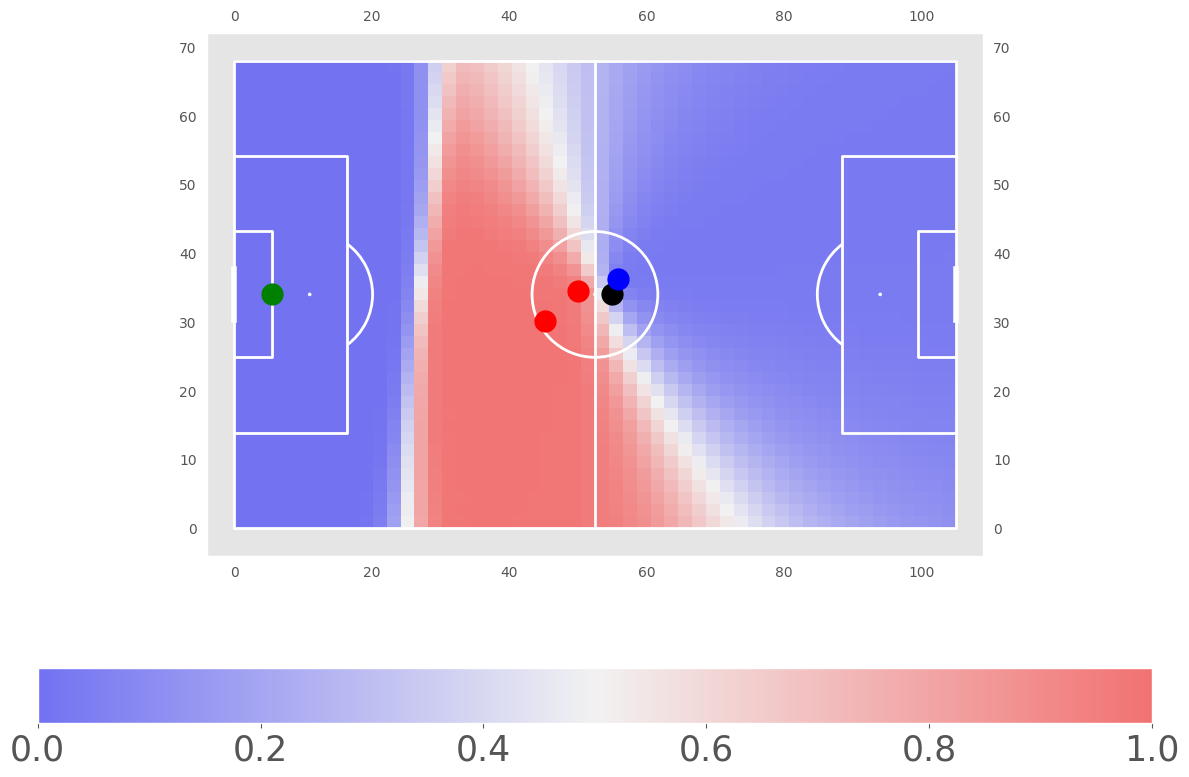

In [20]:
PPCFa, ax, _ = calculate_model_pitch_control(pd.DataFrame(results_df), event_id=356, actual=False)
PPCFa.shape

## Pitch Control Example

In [21]:
df

,pred,target
0,"{'A00': (57.14963150024414, 38.12494659423828)...","{'A00': (57.92000198364258, 25.920000076293945..."
1,"{'A00': (62.05221176147461, 38.298011779785156...","{'A00': (51.584999084472656, 21.94000053405761..."
2,"{'A00': (64.68743133544922, 33.08012771606445)...","{'A00': (54.56000518798828, 18.25), 'A01': (97..."
3,"{'A00': (59.88539123535156, 34.96697998046875)...","{'A00': (60.03499984741211, 13.109999656677246..."
4,"{'A00': (68.61933898925781, 31.233570098876953...","{'A00': (64.71499633789062, 9.859999656677246)..."
...,...,...
1355,"{'A01': (85.26119232177734, 37.66334915161133)...","{'A01': (98.61000061035156, 35.0099983215332),..."
1356,"{'A01': (79.52930450439453, 37.447776794433594...","{'A01': (98.61000061035156, 35.02000045776367)..."
1357,"{'A01': (77.47050476074219, 36.091400146484375...","{'A01': (98.61000061035156, 35.0), 'A02': (49...."
1358,"{'A01': (79.51557922363281, 34.79013442993164)...","{'A01': (98.61000061035156, 35.0), 'A02': (49...."


In [22]:
team_sheets["tracking_id"] = team_sheets.apply(
    lambda t: f'{t["team"][0]}{t["xID"]:02d}', 
    axis=1
)
team_sheets

,player,position,team,jID,player_id,team_id,xID,tracking_id
0,A. Bodzek,None,Home,13,DFL-OBJ-00005H,DFL-CLU-00000P,0,H00
1,R. Hennings,STL,Home,28,DFL-OBJ-00008K,DFL-CLU-00000P,1,H01
2,R. Wolf,None,Home,1,DFL-OBJ-000170,DFL-CLU-00000P,2,H02
3,Matthias Zimmermann,RV,Home,25,DFL-OBJ-0000NZ,DFL-CLU-00000P,3,H03
4,A. Hoffmann,None,Home,3,DFL-OBJ-00006V,DFL-CLU-00000P,4,H04
5,F. Klaus,ORM,Home,11,DFL-OBJ-0000F8,DFL-CLU-00000P,5,H05
6,Jorrit Hendrix,DML,Home,29,DFL-OBJ-J0130T,DFL-CLU-00000P,6,H06
7,M. Sobottka,DMR,Home,31,DFL-OBJ-00028V,DFL-CLU-00000P,7,H07
8,Dawid Kownacki,STR,Home,9,DFL-OBJ-002FXT,DFL-CLU-00000P,8,H08
9,E. Iyoha,OLM,Home,19,DFL-OBJ-0026RH,DFL-CLU-00000P,9,H09


In [23]:
team_sheets_lookup = {
    row["tracking_id"]: {
        "player_id": row["player_id"],
        "team_id":   row["team_id"],
        "position":  row["position"],
        "team": row["team"]
    }
    for _, row in team_sheets.iterrows()
}
team_sheets_lookup

{'H00': {'player_id': 'DFL-OBJ-00005H',
  'team_id': 'DFL-CLU-00000P',
  'position': 'None',
  'team': 'Home'},
 'H01': {'player_id': 'DFL-OBJ-00008K',
  'team_id': 'DFL-CLU-00000P',
  'position': 'STL',
  'team': 'Home'},
 'H02': {'player_id': 'DFL-OBJ-000170',
  'team_id': 'DFL-CLU-00000P',
  'position': 'None',
  'team': 'Home'},
 'H03': {'player_id': 'DFL-OBJ-0000NZ',
  'team_id': 'DFL-CLU-00000P',
  'position': 'RV',
  'team': 'Home'},
 'H04': {'player_id': 'DFL-OBJ-00006V',
  'team_id': 'DFL-CLU-00000P',
  'position': 'None',
  'team': 'Home'},
 'H05': {'player_id': 'DFL-OBJ-0000F8',
  'team_id': 'DFL-CLU-00000P',
  'position': 'ORM',
  'team': 'Home'},
 'H06': {'player_id': 'DFL-OBJ-J0130T',
  'team_id': 'DFL-CLU-00000P',
  'position': 'DML',
  'team': 'Home'},
 'H07': {'player_id': 'DFL-OBJ-00028V',
  'team_id': 'DFL-CLU-00000P',
  'position': 'DMR',
  'team': 'Home'},
 'H08': {'player_id': 'DFL-OBJ-002FXT',
  'team_id': 'DFL-CLU-00000P',
  'position': 'STR',
  'team': 'Home'},

In [24]:
period_tracking_dict = {
    period_id: df.reset_index(drop=True)
    for period_id, df in tracking_data.groupby("period_id")
}
period_tracking_dict

{1:        H00_x  H00_y  H01_x  H01_y  H02_x  H02_y  H03_x  H03_y  H04_x  H04_y  \
 0        NaN    NaN  52.83  34.33    NaN    NaN  43.06  12.32    NaN    NaN   
 1        NaN    NaN  52.82  34.32    NaN    NaN  43.09  12.32    NaN    NaN   
 2        NaN    NaN  52.82  34.30    NaN    NaN  43.11  12.32    NaN    NaN   
 3        NaN    NaN  52.83  34.28    NaN    NaN  43.13  12.33    NaN    NaN   
 4        NaN    NaN  52.84  34.27    NaN    NaN  43.15  12.33    NaN    NaN   
 ...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
 68349    NaN    NaN  70.29  40.56    NaN    NaN  51.67   4.98    NaN    NaN   
 68350    NaN    NaN  70.26  40.53    NaN    NaN  51.68   4.92    NaN    NaN   
 68351    NaN    NaN  70.23  40.49    NaN    NaN  51.70   4.86    NaN    NaN   
 68352    NaN    NaN  70.18  40.46    NaN    NaN  51.72   4.81    NaN    NaN   
 68353    NaN    NaN  70.15  40.42    NaN    NaN  51.73   4.75    NaN    NaN   
 
        ...  A17_speed  A18_vx  A18

In [25]:
results_df = []

for row in tqdm(events.itertuples()):
    event_id = row.event_id

    copy_tracking_data = period_tracking_dict[row.period_id]
    closest_idx = copy_tracking_data["time"].sub(row.time_seconds).abs().idxmin()

    preds = df.loc[event_id, "pred"]
    targets = df.loc[event_id, "target"]

    assert set(preds.keys()) == set(targets.keys()), (f"Key mismatch for event {event_id}")

    for key in preds.keys():
        pred_x, pred_y = preds[key]
        act_x, act_y = targets[key]
        position = team_sheets_lookup[key]["position"]
        
        results_df.append({
            "key": key,
            "event_id": event_id,
            "team_id": team_sheets_lookup[key]["team"], # Home or Away
            "team_on_ball": row.team_id == team_sheets_lookup[key]["team_id"], # tea_id
            "player_on_ball": row.player_id == team_sheets_lookup[key]["player_id"], # player_id
            "position": "GK" if position == "TW" else position,
            "pred_x": pred_x,
            "pred_y": pred_y,
            "act_x": act_x,
            "act_y": act_y,
            "ballx": copy_tracking_data.at[closest_idx, "B00_x"], # actual location
            "bally": copy_tracking_data.at[closest_idx, "B00_y"],
        })

results_df = pd.DataFrame(results_df)
results_df

0it [00:00, ?it/s]

1360it [00:00, 1737.65it/s]


,key,event_id,team_id,team_on_ball,player_on_ball,position,pred_x,pred_y,act_x,act_y,ballx,bally
0,A00,0,Away,False,False,ZO,57.149632,38.124947,57.920002,25.920000,51.68,34.01
1,A01,0,Away,False,False,GK,99.828484,30.788250,100.089996,34.080002,51.68,34.01
2,A05,0,Away,False,False,STZ,51.936680,28.700766,52.530003,43.299999,51.68,34.01
3,A06,0,Away,False,False,RV,60.987782,43.480228,71.330009,49.470001,51.68,34.01
4,A07,0,Away,False,False,OLM,68.983490,39.435276,52.860001,22.090000,51.68,34.01
...,...,...,...,...,...,...,...,...,...,...,...,...
29915,H11,1359,Home,False,False,OLM,17.424334,38.153915,13.795001,41.814999,105.00,37.26
29916,H13,1359,Home,False,False,IVR,18.979057,28.020138,16.515001,45.105000,105.00,37.26
29917,H15,1359,Home,False,False,IVL,11.046209,34.139290,17.480000,27.135000,105.00,37.26
29918,H16,1359,Home,False,False,LV,11.849830,37.915462,16.500000,41.384998,105.00,37.26


In [26]:
event_id = 1144#628
results_df[results_df["event_id"] == event_id]

,key,event_id,team_id,team_on_ball,player_on_ball,position,pred_x,pred_y,act_x,act_y,ballx,bally
25168,A01,1144,Away,False,False,GK,92.959122,29.490551,100.705009,31.885000,28.63,55.63
25169,A02,1144,Away,False,False,IVL,78.284683,5.908889,82.265007,11.475000,28.63,55.63
25170,A03,1144,Away,False,False,ZO,66.166824,12.457545,75.709999,12.245000,28.63,55.63
25171,A05,1144,Away,False,False,STZ,57.455608,17.920616,52.590004,29.709999,28.63,55.63
25172,A06,1144,Away,False,False,RV,72.889687,14.861671,85.980003,10.230000,28.63,55.63
25173,A07,1144,Away,False,False,OLM,77.267944,4.630270,77.730003,4.835000,28.63,55.63
25174,A08,1144,Away,False,False,ORM,74.126808,38.244720,80.370003,22.170000,28.63,55.63
25175,A09,1144,Away,False,False,DMR,67.333694,17.098856,72.125000,10.635000,28.63,55.63
25176,A13,1144,Away,False,False,IVR,86.499161,32.358624,87.989998,24.309999,28.63,55.63
25177,A16,1144,Away,False,False,IVL,86.559181,11.981017,87.739998,35.740002,28.63,55.63


2.019230769230769 1.7435897435897436
visible_area:  ((array([87.28653776]), array([34.03217812])), (array([109.64211447]), array([9.39997])), (array([79.05568838]), array([-6.3369347])), (array([68.6663681]), array([5.11040583])))
not exist ball trajectory


/root/exPress/PlayerImputer/datatools/pitch_control.py:233: RuntimeWarning: divide by zero encountered in scalar divide
  checksum = np.sum( PPCFa + PPCFd ) / float(count)#float(n_grid_cells_y*n_grid_cells_x )


(<Figure size 2080x1440 with 1 Axes>, <Axes: >)

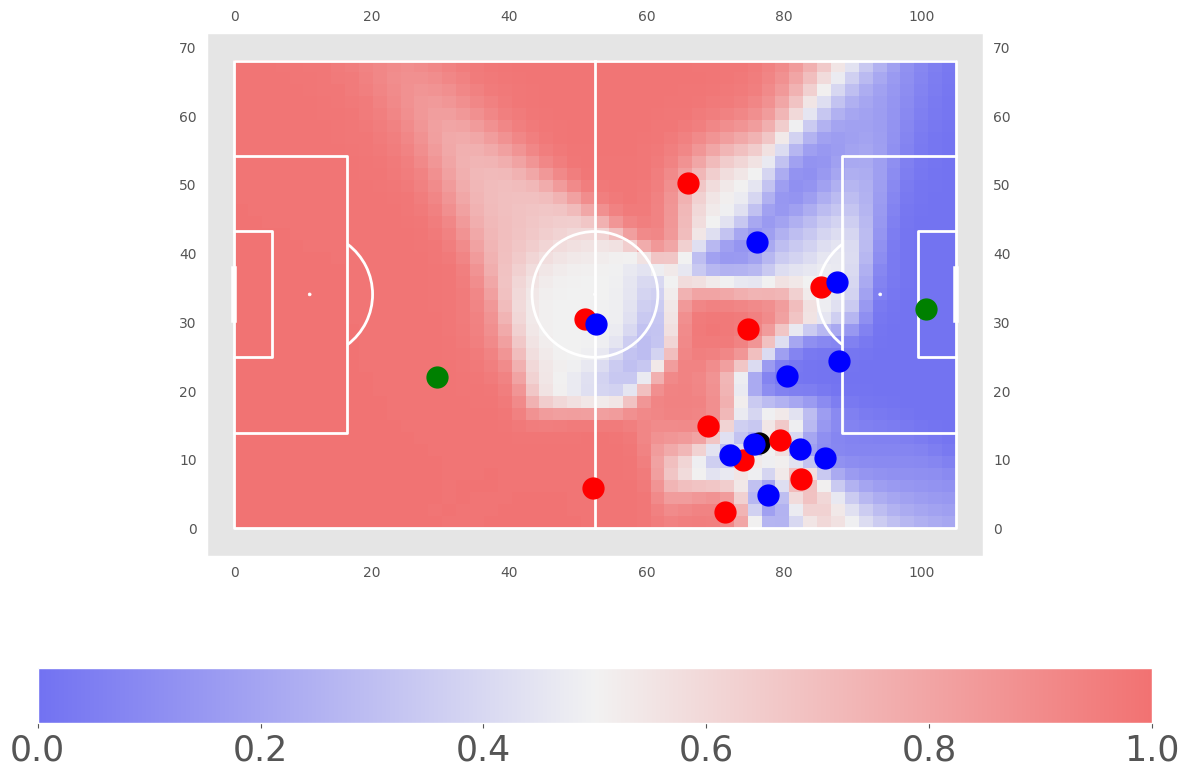

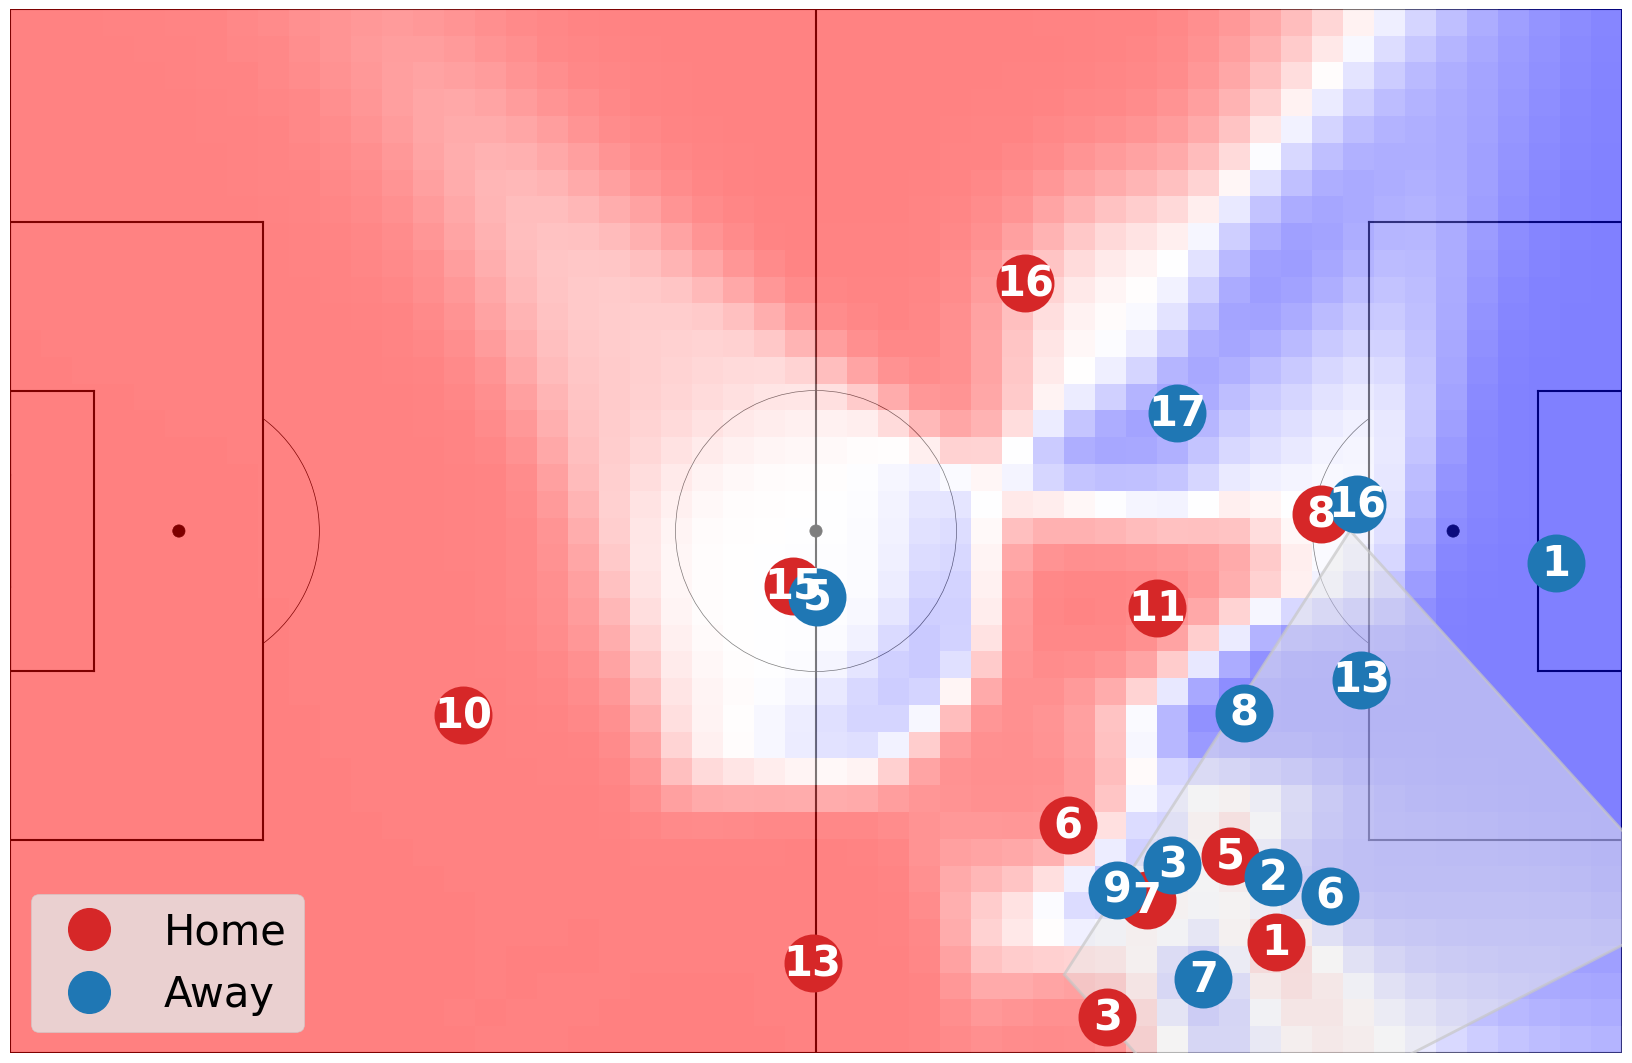

In [27]:
PPCFa, ax, event_df = calculate_model_pitch_control(results_df, event_id=event_id, actual=True, play_left_to_right=False)
plot_pitchcontrol(event_id=event_id, PPCF=PPCFa, locs=event_df)

2.019230769230769 1.7435897435897436


/root/exPress/PlayerImputer/datatools/pitch_control.py:233: RuntimeWarning: divide by zero encountered in scalar divide
  checksum = np.sum( PPCFa + PPCFd ) / float(count)#float(n_grid_cells_y*n_grid_cells_x )


visible_area:  ((array([87.28653776]), array([34.03217812])), (array([109.64211447]), array([9.39997])), (array([79.05568838]), array([-6.3369347])), (array([68.6663681]), array([5.11040583])))
not exist ball trajectory


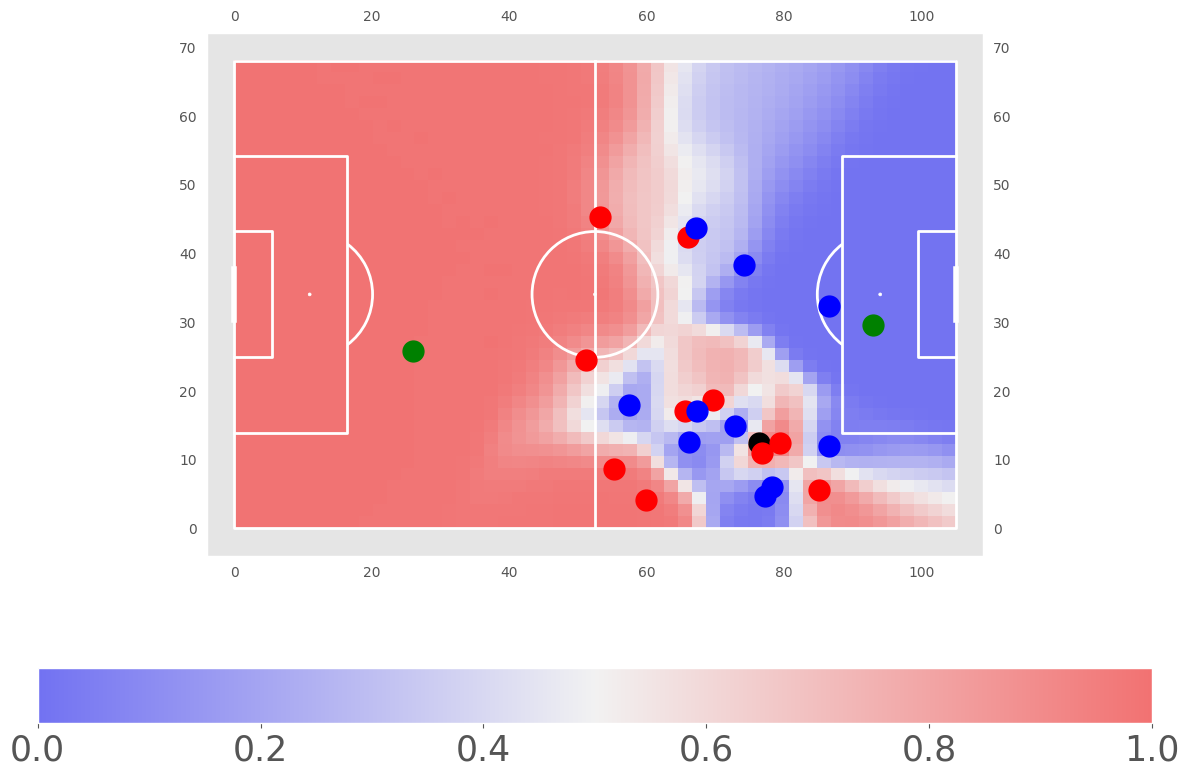

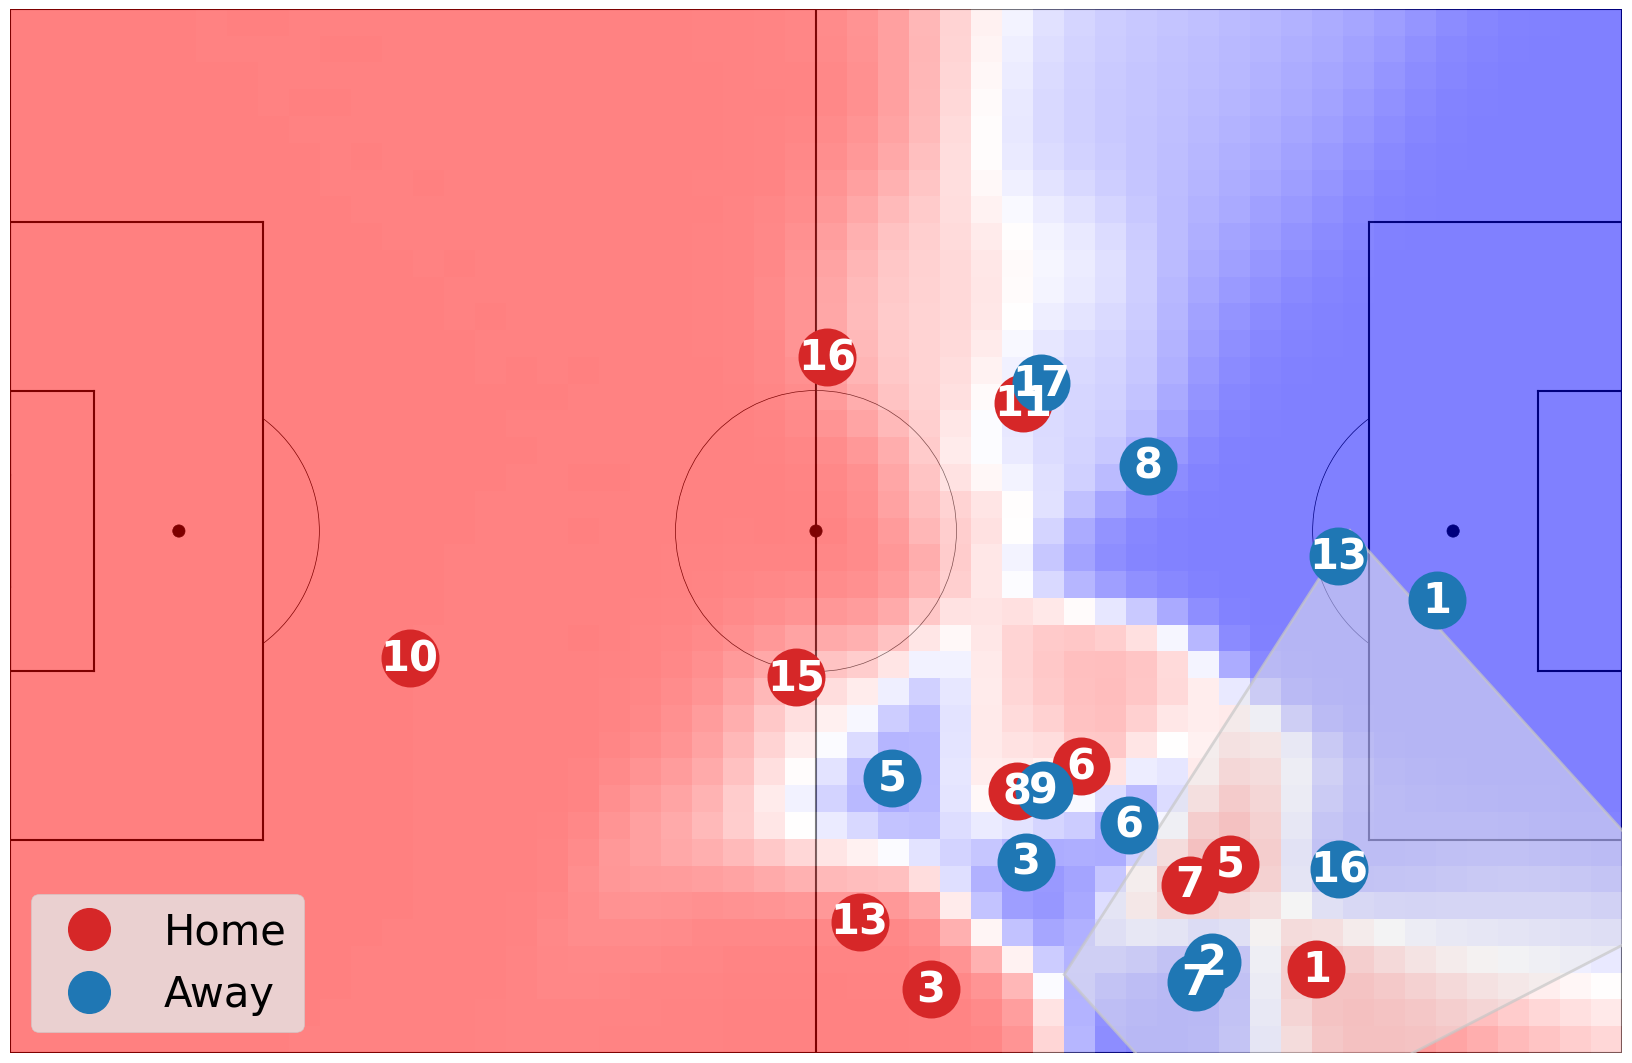

In [30]:
PPCFa, ax, event_df = calculate_model_pitch_control(results_df, event_id=event_id, actual=False, play_left_to_right=False)
fig, ax = plot_pitchcontrol(event_id=event_id, PPCF=PPCFa, locs=event_df)
fig.savefig("agentimputer_pitch_control.pdf", dpi=300, bbox_inches="tight", pad_inches=0.1)

In [29]:
# fig.savefig("agentimputer_pitch_control.pdf", dpi=300, bbox_inches="tight", pad_inches=0.1)